In [92]:
%load_ext autoreload
%autoreload 2
from sympy import symbols, init_printing, simplify, solve
from mako.template import Template
from mako.runtime import Context
from StringIO import StringIO
from fdlib import *
init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Wave equation in 3D

In [2]:
dx, dt, x, y, z, t, c, h = symbols('dx dt x y z t c h')
U = IndexedBase('U')
# 2nd order approximation
n = 2
# list of variables
l = [x,y,z,t]

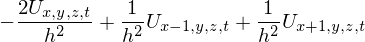

In [4]:
# get the derivative expressions
# using dx = dy = h
Uxx = Deriv(U,l,0,h,n)[2]
Uyy = Deriv(U,l,1,h,n)[2]
Uzz = Deriv(U,l,2,h,n)[2]
Utt = Deriv(U,l,3,dt,n)[2]
Uxx

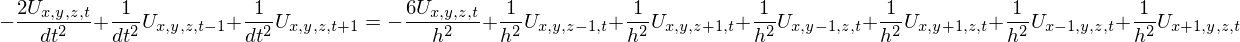

In [5]:
# 2d wave equation
eq = Eq(Utt, (Uxx+Uyy+Uzz))
eq

In [6]:
# generate C code for the body of the loop
code = print_myccode(U[x,y,z,t+1]) + "=" + print_myccode(simplify(solve(eq, U[x,y,z,t+1])[0]))
code

'U[x][y][z][t + 1]=(-6*pow(dt, 2)*U[x][y][z][t] + pow(dt, 2)*U[x][y][z - 1][t] + pow(dt, 2)*U[x][y][z + 1][t] + pow(dt, 2)*U[x][y - 1][z][t] + pow(dt, 2)*U[x][y + 1][z][t] + pow(dt, 2)*U[x - 1][y][z][t] + pow(dt, 2)*U[x + 1][y][z][t] + pow(h, 2)*(2*U[x][y][z][t] - U[x][y][z][t - 1]))/pow(h, 2)'

###Wave equation in 2D

In [7]:
l = [x,t]
Uxx = Deriv(U,l,0,h,n)[2]
Utt = Deriv(U,l,1,dt,n)[2]

In [8]:
eq = Eq(Utt, Uxx)
code = print_myccode(U[x,t+1]) + "=" + print_myccode(simplify(solve(eq, U[x,t+1])[0]))
code

'U[x][t + 1]=(-2*pow(dt, 2)*U[x][t] + pow(dt, 2)*U[x - 1][t] + pow(dt, 2)*U[x + 1][t] + pow(h, 2)*(2*U[x][t] - U[x][t - 1]))/pow(h, 2)'

In [9]:
mytemplate = Template(filename='templates/tmpl1.c')
buf = StringIO()
ctx = Context(buf, loopbody=code)
mytemplate.render_context(ctx)

In [10]:
print(buf.getvalue())

// initialisation
for(int i=0; i<=Nx; i++)
    u[i][0] = I(x[i])
// separate calculation for first time step
for(int i=1; i<Nx; i++)
    u[i][1] = u[i][0]
        -0.5*C**2(u[i+1][0] - 2*u[i][0] + u[i-1][0])
// main loop
for(int n=1; n<Nt; n++){
    // boundary conditions
    u[n+1][0] = 0; u[n+1][Nx] = 0;
    for(int i=1; i<Nx; i++)
    // update mesh points at time = n+1
        U[x][t + 1]=(-2*pow(dt, 2)*U[x][t] + pow(dt, 2)*U[x - 1][t] + pow(dt, 2)*U[x + 1][t] + pow(h, 2)*(2*U[x][t] - U[x][t - 1]))/pow(h, 2)
}



###Propagator

In [32]:
U,V,W,Txx,Tyy,Tzz,Txy,Tyz,Txz = IndexedBases('U V W Txx Tyy Tzz Txy Tyz Txz')
x,y,z,t,h,dt = symbols('x y z t h dt')
b, lam, miu = symbols('b lam miu')

In [40]:
l = [x,y,z,t]

# first-order derivatives of velocities
Ut = Deriv(U,l,3,dt/2,2)[1]
Vt = Deriv(V,l,3,dt/2,2)[1]
Wt = Deriv(W,l,3,dt/2,2)[1]

Ux = Deriv(U,l,0,h/2,2)[1]
Uy = Deriv(U,l,1,h/2,2)[1]
Uz = Deriv(U,l,2,h/2,2)[1]

Vx = Deriv(V,l,0,h/2,2)[1]
Vy = Deriv(V,l,1,h/2,2)[1]
Vz = Deriv(V,l,2,h/2,2)[1]

Wx = Deriv(W,l,0,h/2,2)[1]
Wy = Deriv(W,l,1,h/2,2)[1]
Wz = Deriv(W,l,2,h/2,2)[1]

# first-order derivatives of stresses
DxTxx = Deriv(Txx,l,0,h/2,2)[1]
DyTxy = Deriv(Txy,l,1,h/2,2)[1]
DzTxz = Deriv(Txz,l,2,h/2,2)[1]

DxTxy = Deriv(Txy,l,0,h/2,2)[1]
DyTyy = Deriv(Tyy,l,1,h/2,2)[1]
DzTyz = Deriv(Tyz,l,2,h/2,2)[1]

DxTxz = Deriv(Txz,l,0,h/2,2)[1]
DyTyz = Deriv(Tyz,l,1,h/2,2)[1]
DzTzz = Deriv(Tzz,l,2,h/2,2)[1]

DtTxx = Deriv(Txx,l,3,dt/2,2)[1]
DtTxy = Deriv(Txy,l,3,dt/2,2)[1]
DtTxz = Deriv(Txz,l,3,dt/2,2)[1]
DtTyy = Deriv(Tyy,l,3,h,2)[1]
DtTyz = Deriv(Tyz,l,3,h,2)[1]
DtTzz = Deriv(Tzz,l,3,h,2)[1]

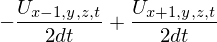

In [51]:
D

In [43]:
# momentum equations
eq1 = Eq(Ut, b*(DxTxx + DyTxy + DzTxz))
eq2 = Eq(Vt, b*(DxTxy + DyTyy + DzTyz))
eq3 = Eq(Wt, b*(DxTxz + DyTyz + DzTzz))

In [99]:
# stress-strain equations
eq4 = Eq(DtTxx, (lam + 2*miu)*Ux + lam*(Vy+Wz))
eq5 = Eq(DtTyy, (lam + 2*miu)*Vy + lam*(Ux+Wz))
eq6 = Eq(DtTzz, (lam + 2*miu)*Wz + lam*(Ux+Vy))
eq7 = Eq(DtTxy, miu*(Uy+Vx))
eq8 = Eq(DtTxz, miu*(Uz+Wx))
eq9 = Eq(DtTyz, miu*(Vz+Wy))

In [100]:
eqs = [eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9]

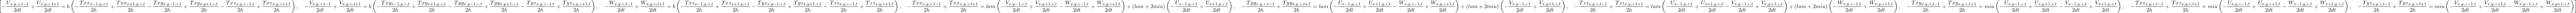

In [101]:
eqs

In [104]:
U_t = print_increment(eq1, U[x,y,z,t+1], U[x,y,z,t-1])
V_t = print_increment(eq2, V[x,y,z,t+1], V[x,y,z,t-1])
W_t = print_increment(eq3, W[x,y,z,t+1], W[x,y,z,t-1])

Txx_t = print_increment(eq4, Txx[x,y,z,t+1], Txx[x,y,z,t-1])
Tyy_t = print_increment(eq5, Tyy[x,y,z,t+1], Tyy[x,y,z,t-1])
Tzz_t = print_increment(eq6, Tzz[x,y,z,t+1], Tzz[x,y,z,t-1])
Txy_t = print_increment(eq7, Txy[x,y,z,t+1], Txy[x,y,z,t-1])
Txz_t = print_increment(eq8, Txz[x,y,z,t+1], Txz[x,y,z,t-1])
Tyz_t = print_increment(eq9, Tyz[x,y,z,t+1], Tyz[x,y,z,t-1])

In [106]:
U_t

'U[x][y][z][t + 1]+=b*dt*(-Txx[x - 1][y][z][t] + Txx[x + 1][y][z][t] - Txy[x][y - 1][z][t] + Txy[x][y + 1][z][t] - Txz[x][y][z - 1][t] + Txz[x][y][z + 1][t])/h'